In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load data

In [2]:
df = pd.read_csv(\
f'/Volumes/GoogleDrive/My Drive/wish_local/local_pick_up_time_analysis/Data/fusion_pick_up_time.csv', \
                low_memory=False, \
                infer_datetime_format=True)
df.head(2)

,c_transaction_id,variation_id,store_id,store_country,picked_up_time,transaction_time,store_scan_time,operation_hours
0,5dffb900855c4de37761b4fe,5d8d7cd251cb860a4374e200,5c9be468711be7284e36d77b,US,1578781457,1577040128,1578683349,10:00-15:00|10:00-15:00|10:00-15:00|10:00-15:0...
1,5f95f4151a2cd8d2240c5d48,5c359f8dd5b4537177a8a6cc,5d3af43a83889719a928d148,IT,1606116780,1603662869,1605344212,"08:30-13:30,15:30-18:30|08:30-13:30,15:30-18:3..."


In [3]:
df.shape

(6195821, 8)

In [4]:
df.isna().sum()

c_transaction_id    0
variation_id        0
store_id            0
store_country       0
picked_up_time      0
transaction_time    0
store_scan_time     0
operation_hours     0
dtype: int64

# Clean data

## scan_to_pick_time

In [5]:
df['scan_to_pick_seconds'] = df['picked_up_time'] - df['store_scan_time']


In [6]:
df[['scan_to_pick_seconds', 'picked_up_time', 'store_scan_time']]

,scan_to_pick_seconds,picked_up_time,store_scan_time
0,98108,1578781457,1578683349
1,772568,1606116780,1605344212
2,83561,1605345201,1605261640
3,13152,1607470966,1607457814
4,342149,1601930643,1601588494
...,...,...,...
6195816,8332,1607639860,1607631528
6195817,448423,1606922170,1606473747
6195818,15657,1606860876,1606845219
6195819,312469,1580309588,1579997119


In [7]:
(df[['scan_to_pick_seconds']]/3600/24).describe()

,scan_to_pick_seconds
count,6.195821e+06
mean,4.487601e+00
std,5.821620e+00
min,-2.000525e+01
25%,9.248495e-01
50%,2.868380e+00
75%,6.141956e+00
max,2.701496e+02


In [8]:
(df[['scan_to_pick_seconds']]).describe()

,scan_to_pick_seconds
count,6.195821e+06
mean,3.877287e+05
std,5.029880e+05
min,-1.728454e+06
25%,7.990700e+04
50%,2.478280e+05
75%,5.306650e+05
max,2.334092e+07


## operation hours per week

In [26]:
from datetime import datetime
def operation_hours_per_day(d):
    if d == 'Closed':
        return 0 
    
    periods = d.split(',')
    hours = 0
    for p in periods:
        start, end = p.split('-')[0], p.split('-')[1]
        if (start == end) and (start=='00:00'): # open 24 hours
            hours += 24
        else:
            h = (datetime.strptime(end, "%H:%M") - datetime.strptime(start, "%H:%M")).seconds / 3600
            hours += h
            
    return hours
    

def operation_hours_per_week(x):
    days = x.split('|')
    hours = []
    for d in days:
        hours.append(operation_hours_per_day(d))
                
    return hours
    
store_hours = df[['store_id', 'operation_hours']].drop_duplicates()
store_hours['operation_hours_per_week'] = store_hours['operation_hours'].apply(operation_hours_per_week)
store_hours_dict = store_hours[['store_id', 'operation_hours_per_week']].set_index('store_id').to_dict(\
                                                            )['operation_hours_per_week']
df['operaion_hours_per_week'] = df['store_id'].apply(lambda x: store_hours_dict[x])
 
df['total_operaion_hours_per_week'] = df['operaion_hours_per_week'].apply(sum)

<AxesSubplot:>

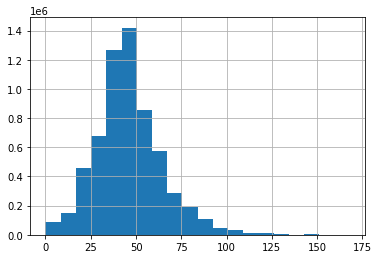

In [27]:
df['total_operaion_hours_per_week'].hist(bins=20)

## pay_date, trans_date, pick_up_date, pick_up_calendar_days

In [28]:
from datetime import datetime, timezone
import pytz
country_timezone = {'US': 'America/Los_Angeles',\
                    'MX': 'America/Mexico_City',\
                    'IT': 'Europe/Rome'}#,\
#                     'FR': 'Europe/Paris',\
#                     'ES': 'Europe/Madrid',\
#                     'GB': 'Europe/London',\
#                     'DE': 'Europe/Berlin'}

def unix_time_to_local_date(date, country):
    if country in country_timezone:
        local_timezone = country_timezone[country]
        return datetime.fromtimestamp(date, pytz.timezone(local_timezone)).date()#.strftime("%Y-%m")
    else:
        return datetime.fromtimestamp(date, pytz.timezone('UTC')).date()#.strftime("%Y-%m")


In [29]:
df['picked_up_date_local'] = df.apply(\
        lambda x: unix_time_to_local_date(date=x['picked_up_time'], country=x['store_country']), axis=1)
df['scan_date_local'] = df.apply(\
        lambda x: unix_time_to_local_date(date=x['store_scan_time'], country=x['store_country']), axis=1)

df['scan_to_pick_local_days'] = (df['picked_up_date_local'] -\
                                        df['scan_date_local']).apply(lambda x: x.days)


## Apply final filters

### Exclude non-negative scan_to_pick_seconds

In [30]:
df[df['scan_to_pick_seconds'] < 0].shape

(1, 14)

In [31]:
df = df[df['scan_to_pick_seconds'] >= 0]

### Exclude some countries

In [32]:
fusion_countries = set(country_timezone.keys())
df = df[df['store_country'].apply(lambda x: x in fusion_countries)]

In [33]:
df.shape

(6195820, 14)

# Exclude offline cash

# operation hours and pick up time

Text(0.5, 1.0, 'Fusion store operation time and pick up time')

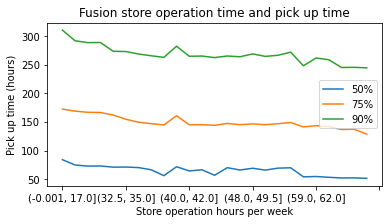

In [54]:
df['total_operaion_hours_per_week_q25'] = pd.qcut(df['total_operaion_hours_per_week'], 25)
temp = (df.groupby('total_operaion_hours_per_week_q25')['scan_to_pick_seconds'].quantile(\
                                        [0.5, .75, .9])/3600).unstack()
# # temp = (df.groupby('total_operaion_hours_per_week_q20')['pay_to_pick_local_days'].quantile(\
#                                         [0.5, .75, .9])).unstack()
temp.columns = ['50%', '75%', '90%']
temp.plot(figsize=(6, 3))
plt.legend()
plt.xlabel('Store operation hours per week')
plt.ylabel('Pick up time (hours)')
plt.title('Fusion store operation time and pick up time')

In [55]:
temp

,50%,75%,90%
total_operaion_hours_per_week_q25,,,
"(-0.001, 17.0]",84.037500,172.438056,310.384139
"(17.0, 22.5]",74.735556,168.853611,291.726667
"(22.5, 27.0]",72.828472,166.860972,288.567361
"(27.0, 30.0]",73.041667,166.455486,288.768083
"(30.0, 32.5]",71.005556,161.999514,273.461833
"(32.5, 35.0]",71.193611,154.681389,272.950889
"(35.0, 36.0]",70.210972,149.511111,268.668611
"(36.0, 37.5]",66.401111,146.945486,265.572083
"(37.5, 39.0]",56.093333,144.756111,262.806667


In [50]:
#temp.to_csv('Data/fusion_operation_hour_pick_up_time.csv')

# Pick up time analysis

## Hours

In [39]:
df.loc[:,'picked_up_yearmonth'] = df['picked_up_date_local'].apply(\
                                                                lambda x: x.strftime("%Y-%m"))
df.loc[:,'scan_yearmonth'] = df['scan_date_local'].apply(\
                                                                lambda x: x.strftime("%Y-%m"))

# df.loc[:,'transaction_yearmonth'] = df['transaction_date_local'].apply(\
#                                                                 lambda x: x.strftime("%Y-%m"))
# df.loc[:,'pay_yearmonth'] = df['pay_date_local'].apply(\
#                                                                 lambda x: x.strftime("%Y-%m"))

In [40]:
# df.loc[:,'trans_to_pick_days'] = df['trans_to_pick_seconds'] / (60 * 60 * 24)
df.groupby(['store_country', 'scan_yearmonth'])['scan_to_pick_local_days'].describe(\
                                        percentiles=[.25, .5,.75,.85,.90,.95,.99]).round(1)#.astype(int)

count  mean   std   min   25%   50%   75%  \
store_country scan_yearmonth                                                 
IT            2020-01         366882.0   3.2   3.5   0.0   1.0   2.0   5.0   
              2020-02         108310.0   3.3   3.7   0.0   1.0   2.0   5.0   
              2020-03          77812.0  13.4  17.0   0.0   1.0   5.0  20.0   
              2020-04          14865.0  16.2  15.5   0.0   3.0  11.0  28.0   
              2020-05           7478.0   9.1  11.3   0.0   2.0   5.0  12.0   
              2020-06          56539.0   5.8   7.7   0.0   1.0   3.0   7.0   
              2020-07         173902.0   3.8   4.2   0.0   1.0   2.0   6.0   
              2020-08         158440.0   3.9   4.2   0.0   1.0   2.0   6.0   
              2020-09         220791.0   3.4   3.8   0.0   1.0   2.0   5.0   
              2020-10         319871.0   3.1   3.6   0.0   0.0   2.0   5.0   
              2020-11         467788.0   3.5   5.2   0.0   1.0   2.0   4.0   
              2020-12         320522.0   2.6   3.2   0.0   0.0   1.0   4.0   
MX            2019-12              4.0  13.8   0.5  13.0  13.8  14.0  14.0   
              2020-01          67509.0   4.1   4.1   0.0   1.0   3.0   6.0   
              2020-02          84776.0   3.9   4.0   0.0   1.0   3.0   6.0   
              2020-03          29870.0   7.3  10.7   0.0   1.0   3.0   8.0   
              2020-04          12441.0  10.4  13.5   0.0   1.0   5.0  13.0   
              2020-05           1444.0  10.3  12.6   0.0   2.0   5.0  14.0   
              2020-06          25208.0   5.7   7.9   0.0   1.0   3.0   7.0   
              2020-07          77147.0   4.3   5.2   0.0   1.0   3.0   6.0   
              2020-08          74141.0   3.7   4.0   0.0   1.0   2.0   5.0   
              2020-09          75456.0   3.4   3.9   0.0   1.0   2.0   5.0   
              2020-10          89195.0   3.4   3.8   0.0   1.0   2.0   5.0   
              2020-11          89448.0   3.3   3.7   0.0   1.0   2.0   5.0   
              2020-12         114523.0   2.9   3.4   0.0   0.0   2.0   4.0   
US            2019-12            554.0   5.1   3.9   0.0   2.0   3.0   8.0   
              2020-01         456305.0   4.4   4.2   0.0   1.0   3.0   7.0   
              2020-02         293789.0   4.5   4.4   0.0   1.0   3.0   7.0   
              2020-03         113531.0   9.9  13.3   0.0   1.0   5.0  12.0   
              2020-04          89008.0  12.2  14.0   0.0   2.0   7.0  17.0   
              2020-05          18885.0  11.1  13.3   0.0   2.0   7.0  15.0   
              2020-06           5515.0   9.5  10.5   0.0   2.0   6.0  14.0   
              2020-07         288881.0   6.1   6.9   0.0   1.0   4.0   8.0   
              2020-08         407881.0   4.8   4.6   0.0   1.0   4.0   7.0   
              2020-09         316899.0   4.6   4.3   0.0   1.0   3.0   7.0   
              2020-10         337548.0   4.5   4.2   0.0   1.0   3.0   7.0   
              2020-11         382119.0   4.6   4.2   0.0   1.0   3.0   7.0   
              2020-12         450543.0   3.8   3.8   0.0   1.0   3.0   6.0   

                               85%   90%   95%   99%    max  
store_country scan_yearmonth                                 
IT            2020-01          7.0   8.0  11.0  14.0   29.0  
              2020-02          7.0   9.0  12.0  15.0   16.0  
              2020-03         37.0  43.0  52.0  59.0   70.0  
              2020-04         35.0  40.0  47.0  58.0   62.0  
              2020-05         19.0  25.0  36.0  48.0   61.0  
              2020-06         12.0  15.0  22.0  38.0   47.0  
              2020-07          8.0  10.0  13.0  16.0   50.0  
              2020-08          9.0  11.0  13.0  15.0   45.0  
              2020-09          7.0   9.0  12.0  15.0   44.0  
              2020-10          7.0   8.0  12.0  15.0   25.0  
              2020-11          7.0   9.0  13.0  27.0   47.0  
              2020-12          5.0   7.0   9.0  14.0   33.0  
MX            2019-12         14.0  14.0  14

## Calendar days

In [41]:
df.groupby(['store_country', 'scan_yearmonth'])[\
        'scan_to_pick_local_days'].describe(percentiles=[.5,.75,.85,.90,.95,.99]\
                                                    )#.to_csv('Data/fusion_country_pick_up_calendar_days.csv')

count       mean        std   min   50%  \
store_country scan_yearmonth                                               
IT            2020-01         366882.0   3.177079   3.533790   0.0   2.0   
              2020-02         108310.0   3.317755   3.680387   0.0   2.0   
              2020-03          77812.0  13.437323  17.016405   0.0   5.0   
              2020-04          14865.0  16.215540  15.453182   0.0  11.0   
              2020-05           7478.0   9.105777  11.345731   0.0   5.0   
              2020-06          56539.0   5.796512   7.678281   0.0   3.0   
              2020-07         173902.0   3.783424   4.221543   0.0   2.0   
              2020-08         158440.0   3.896926   4.200490   0.0   2.0   
              2020-09         220791.0   3.411321   3.791969   0.0   2.0   
              2020-10         319871.0   3.142604   3.609254   0.0   2.0   
              2020-11         467788.0   3.549270   5.190278   0.0   2.0   
              2020-12         320522.0   2.555219   3.210771   0.0   1.0   
MX            2019-12              4.0  13.750000   0.500000  13.0  14.0   
              2020-01          67509.0   4.057385   4.078552   0.0   3.0   
              2020-02          84776.0   3.917264   4.036559   0.0   3.0   
              2020-03          29870.0   7.313927  10.693430   0.0   3.0   
              2020-04          12441.0  10.404148  13.504215   0.0   5.0   
              2020-05           1444.0  10.287396  12.565441   0.0   5.0   
              2020-06          25208.0   5.727190   7.902295   0.0   3.0   
              2020-07          77147.0   4.275176   5.238064   0.0   3.0   
              2020-08          74141.0   3.674283   4.003147   0.0   2.0   
              2020-09          75456.0   3.448765   3.855786   0.0   2.0   
              2020-10          89195.0   3.420080   3.796800   0.0   2.0   
              2020-11          89448.0   3.342422   3.727781   0.0   2.0   
              2020-12         114523.0   2.886171   3.386817   0.0   2.0   
US            2019-12            554.0   5.117329   3.881000   0.0   3.0   
              2020-01         456305.0   4.381177   4.249196   0.0   3.0   
              2020-02         293789.0   4.496322   4.356251   0.0   3.0   
              2020-03         113531.0   9.945724  13.277166   0.0   5.0   
              2020-04          89008.0  12.158098  13.994158   0.0   7.0   
              2020-05          18885.0  11.123061  13.349727   0.0   7.0   
              2020-06           5515.0   9.546872  10.478181   0.0   6.0   
              2020-07         288881.0   6.086728   6.883330   0.0   4.0   
              2020-08         407881.0   4.806701   4.592836   0.0   4.0   
              2020-09         316899.0   4.621479   4.319662   0.0   3.0   
              2020-10         337548.0   4.518033   4.236029   0.0   3.0   
              2020-11         382119.0   4.566536   4.235513   0.0   3.0   
              2020-12         450543.0   3.765942   3.789764   0.0   3.0   

                               75%    85%   90%   95%   99%    max  
store_country scan_yearmonth                                        
IT            2020-01          5.0   7.00   8.0  11.0  14.0   29.0  
              2020-02          5.0   7.00   9.0  12.0  15.0   16.0  
              2020-03         20.0  37.00  43.0  52.0  59.0   70.0  
              2020-04         28.0  35.00  40.0  47.0  58.0   62.0  
              2020-05         12.0  19.00  25.0  36.0  48.0   61.0  
              2020-06          7.0  12.00  15.0  22.0  38.0   47.0  
              2020-07          6.0   8.00  10.0  13.0  16.0   50.0  
              2020-08          6.0   9.00  11.0  13.0  15.0   45.0  
              2020-09          5.0   7.00   9.0  12.0  15.0   44.0  
              2020-10          5.0   7.00   8.0  12.0  15.0   25.0  
              2020-11          4.0   7.00   9.0  13.0  27.0   47.0  
              2020-12          4.0   5.00   7.0   9.0  14.0   33.0  
MX            2019-12     

## Calendar days w/ operation days considered

In [42]:
def open_days_from_day1_to_picked_date(row):
    '''
    return total number of open days from pay_date(exclusive) and picked_up_date(inclusive) 
    
    '''
    days_between = row['scan_to_pick_local_days']
    
    if days_between == 0: # picked up on the same day
        return 0 
    
    day1 = (row['scan_date_local'].weekday() + 1) % 7 # weekday after transaction date
    op_hours = row['operation_hours'].split('|') 
    
    # ex: [False, False, True, True, True, True, False]. open or not, from Monday to Sunday
    op_hours_boolen = [False if d == 'Closed' else True for d in op_hours] 
    
    # number of entire weeks, floor division * number of open days in one week
    whole_weeks = (days_between // 7) * sum(op_hours_boolen)
    
    # number of open days in the remain days
    op_hours_boolen_two_weeks = op_hours_boolen + op_hours_boolen
    remainder_days = sum(op_hours_boolen_two_weeks[day1 : day1+(days_between%7)])
    
    # return total number of open days
    return whole_weeks + remainder_days
    
df['scan_to_pick_local_days_open'] = df.apply(\
                                                    open_days_from_day1_to_picked_date, axis=1)

In [46]:
df.groupby(['store_country', 'scan_yearmonth'])['scan_to_pick_local_days_open'].describe(\
                    percentiles=[.5,.75,.85,.90,.95,.99])#.to_csv('Data/fusion_country_pick_up_open_days.csv')

count       mean        std  min   50%   75%  \
store_country scan_yearmonth                                                    
IT            2020-01         366882.0   2.631320   2.955800  0.0   2.0   4.0   
              2020-02         108310.0   2.748057   3.090197  0.0   2.0   4.0   
              2020-03          77812.0  11.399013  14.529599  0.0   4.0  16.0   
              2020-04          14865.0  13.513824  13.229116  0.0   9.0  22.0   
              2020-05           7478.0   7.595748   9.513236  0.0   4.0  10.0   
              2020-06          56539.0   4.882594   6.521188  0.0   3.0   6.0   
              2020-07         173902.0   3.161672   3.560898  0.0   2.0   5.0   
              2020-08         158440.0   3.307037   3.574168  0.0   2.0   5.0   
              2020-09         220791.0   2.912918   3.225691  0.0   2.0   4.0   
              2020-10         319871.0   2.642543   3.061598  0.0   2.0   4.0   
              2020-11         467788.0   3.001413   4.395608  0.0   1.0   4.0   
              2020-12         320522.0   2.179804   2.718320  0.0   1.0   3.0   
MX            2019-12              4.0   9.750000   0.500000  9.0  10.0  10.0   
              2020-01          67509.0   3.363477   3.463646  0.0   2.0   5.0   
              2020-02          84776.0   3.197591   3.413034  0.0   2.0   5.0   
              2020-03          29870.0   6.094744   8.964734  0.0   3.0   7.0   
              2020-04          12441.0   8.688369  11.372743  0.0   4.0  11.0   
              2020-05           1444.0   8.255540  10.372638  0.0   4.0  11.0   
              2020-06          25208.0   4.839614   6.773236  0.0   2.0   6.0   
              2020-07          77147.0   3.592790   4.509067  0.0   2.0   5.0   
              2020-08          74141.0   3.089370   3.446097  0.0   2.0   5.0   
              2020-09          75456.0   2.947585   3.325394  0.0   2.0   4.0   
              2020-10          89195.0   2.882303   3.282101  0.0   2.0   4.0   
              2020-11          89448.0   2.850897   3.206874  0.0   2.0   4.0   
              2020-12         114523.0   2.462449   2.920967  0.0   1.0   3.0   
US            2019-12            554.0   4.694946   3.741040  0.0   3.0   7.0   
              2020-01         456305.0   3.517373   3.584022  0.0   2.0   5.0   
              2020-02         293789.0   3.622995   3.674868  0.0   2.0   5.0   
              2020-03         113531.0   8.145282  11.150351  0.0   4.0  10.0   
              2020-04          89008.0   9.890527  11.806777  0.0   5.0  13.0   
              2020-05          18885.0   8.635107  10.934072  0.0   5.0  12.0   
              2020-06           5515.0   7.457117   8.426135  0.0   5.0  10.0   
              2020-07         288881.0   5.013272   5.851370  0.0   3.0   7.0   
              2020-08         407881.0   3.900363   3.886547  0.0   3.0   6.0   
              2020-09         316899.0   3.753319   3.616174  0.0   3.0   6.0   
              2020-10         337548.0   3.654538   3.581879  0.0   3.0   5.0   
              2020-11         382119.0   3.751509   3.594417  0.0   3.0   6.0   
              2020-12         450543.0   3.106163   3.180597  0.0   2.0   4.0   

                               85%   90%    95%   99%    max  
store_country scan_yearmonth                                  
IT            2020-01          5.0   7.0   9.00  13.0   29.0  
              2020-02          6.0   7.0  10.00  13.0   16.0  
              2020-03         31.0  37.0  44.00  52.0   61.0  
              2020-04         29.0  34.0  40.00  50.0   61.0  
              2020-05         16.0  21.0  30.00  41.0   59.0  
              2020-06         10.0  13.0  19.00  32.0   46.0  
              2020-07          7.0   8.0  11.00  14.0   46.0  
              2020-08          7.0   9.0  11.00  14.0   45.0  
              2020-09          6.0   8.0  10.00  13.0   37.0  
              2020-10          6.0   7.0  10.00  13.0   17.0  
              2020-11          6.0  

In [31]:
# for c in fusion_countries:
#     temp = df[df['store_country']==c].groupby(['transaction_yearmonth'])['trans_to_pick_local_days_open'].describe(\
#                                             percentiles=[.5,.75,.85,.90,.95,.99])

#     temp.iloc[1:][['50%', '75%', '85%', '90%', '95%', '99%']].plot()

In [44]:
df.head()

,c_transaction_id,variation_id,store_id,store_country,picked_up_time,transaction_time,store_scan_time,operation_hours,scan_to_pick_seconds,operaion_hours_per_week,total_operaion_hours_per_week,picked_up_date_local,scan_date_local,scan_to_pick_local_days,total_operaion_hours_per_week_q25,picked_up_yearmonth,scan_yearmonth,scan_to_pick_local_days_open
0,5dffb900855c4de37761b4fe,5d8d7cd251cb860a4374e200,5c9be468711be7284e36d77b,US,1578781457,1577040128,1578683349,10:00-15:00|10:00-15:00|10:00-15:00|10:00-15:0...,98108,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]",35.0,2020-01-11,2020-01-10,1,"(32.5, 35.0]",2020-01,2020-01,1
1,5f95f4151a2cd8d2240c5d48,5c359f8dd5b4537177a8a6cc,5d3af43a83889719a928d148,IT,1606116780,1603662869,1605344212,"08:30-13:30,15:30-18:30|08:30-13:30,15:30-18:3...",772568,"[8.0, 8.0, 8.0, 8.0, 8.0, 4.0, 0]",44.0,2020-11-23,2020-11-14,9,"(43.5, 45.0]",2020-11,2020-11,7
2,5f95c63fe98387f43ff349cf,5ee2e12f2b84ac106bed4fee,5d4d39c28388975d21e6b92b,IT,1605345201,1603651135,1605261640,"09:00-13:00,16:00-20:00|09:00-13:00,16:00-20:0...",83561,"[8.0, 8.0, 8.0, 8.0, 8.0, 11.0, 0]",51.0,2020-11-14,2020-11-13,1,"(49.5, 52.0]",2020-11,2020-11,1
3,5fa55b4e361bd133033eb2aa,5dfc57b0e41b2c06953ce2cb,5e2f36ec5fb2a68b4e36243e,US,1607470966,1604672334,1607457814,Closed|10:00-18:00|10:00-18:00|10:00-18:00|10:...,13152,"[0, 8.0, 8.0, 8.0, 8.0, 8.0, 0]",40.0,2020-12-08,2020-12-08,0,"(39.0, 40.0]",2020-12,2020-12,0
4,5f63e537c8a16d6bbda8675d,5f351b49fa7c3549a943f2ec,5d5c311b40defd756057b320,US,1601930643,1600382263,1601588494,10:00-17:00|10:00-17:00|10:00-17:00|10:00-18:0...,342149,"[7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 0]",45.0,2020-10-05,2020-10-01,4,"(43.5, 45.0]",2020-10,2020-10,3


# Export cleaned data

In [47]:
df.to_csv('Data/fusion_all_countries_cleaned.csv')

# Import cleaned data

In [9]:
dates = ['picked_up_date_local', 'transaction_date_local', 'pay_date_local']
df = pd.read_csv('Data/data_all_countries_variation_level_cleaned.csv', \
                 index_col=0, \
                 parse_dates=dates, infer_datetime_format=True)
df.loc[:,'pay_yearmonth'] = df['pay_date_local'].apply(\
                                                                lambda x: x.strftime("%Y-%m"))

/Users/mshi/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
df.head()

,transaction_id,variation_id,picked_up_time,payment_received_time,transaction_time,shipping_country,user_id,store_id,store_country,zipcode,state,city,operation_hours,time,pay_to_pick_seconds,trans_to_pick_seconds,operaion_hours_per_week,total_operaion_hours_per_week,picked_up_date_local,transaction_date_local,pay_date_local,trans_to_pick_local_days,pay_to_pick_local_days,trans_to_pick_days,picked_up_yearmonth,transaction_yearmonth,total_operaion_hours_per_week_q20,trans_to_pick_local_days_open,pay_yearmonth
2,5e5b79acbc949708839014b8,5c4a036288717a269679be73,1583513427,1583053230,1583053228,ES,5b564525cd893e47a836d285,5d710f2325da6b5873a53c76,ES,08031,BARCELONA,BARCELONA,10:00-13:00|10:00-13:00|10:00-13:00|10:00-13:0...,1612210614,460197,460199,"[3.0, 3.0, 3.0, 3.0, 3.0, 0, 0]",15.0,2020-03-06,2020-03-01,2020-03-01,5,5,5.326377,2020-03,2020-03,"(-0.001, 16.25]",5,2020-03
3,5ebe08abac178e762bffaa8b,5c256c2f93a8ff35aae339e5,1589638166,1589512368,1589512363,FR,5ebe0337619812c42589bf7b,5c2d81e86fa88c9e2cfa8cdb,FR,75020,NaN,Paris,10:00-19:00|10:00-19:00|10:00-19:00|10:00-19:0...,1612210614,125798,125803,"[9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 0]",54.0,2020-05-16,2020-05-15,2020-05-15,1,1,1.456053,2020-05,2020-05,"(52.0, 54.0]",1,2020-05
4,5da5ca7891f7c46a72a80b69,5c240769a2d784229bb1ece1,1571304344,1571146363,1571146360,FR,5cc56acb3d8fca73ed7d1424,5cad0c58fd8e9a2ec1125a65,FR,88000,Vosges,Epinal,"09:00-12:00,14:00-20:00|09:00-12:00,13:30-20:0...",1612210614,157981,157984,"[9.0, 9.5, 9.5, 9.5, 8.0, 11.0, 6.5]",63.0,2019-10-17,2019-10-15,2019-10-15,2,2,1.828519,2019-10,2019-10,"(62.5, 69.0]",2,2019-10
7,5ddafba3f9432da02b1aac1e,5c17e1b697b7682234512e65,1574634099,1574632360,1574632355,US,5d1717db0050e1128367ccee,5d7001b451da4f05fc989c46,US,89102,Nevada,Las Vegas,Closed|Closed|Closed|Closed|10:00-18:00|10:00-...,1612210614,1739,1744,"[0, 0, 0, 0, 8.0, 8.0, 8.0]",24.0,2019-11-24,2019-11-24,2019-11-24,0,0,0.020185,2019-11,2019-11,"(16.25, 24.0]",0,2019-11
8,5dfd6de9a5027810794b00ee,5c344471b1ca0d7eddf795e8,1576890566,1576889835,1576889833,US,5d1717db0050e1128367ccee,5d7001b451da4f05fc989c46,US,89102,Nevada,Las Vegas,Closed|Closed|Closed|Closed|10:00-18:00|10:00-...,1612210614,731,733,"[0, 0, 0, 0, 8.0, 8.0, 8.0]",24.0,2019-12-20,2019-12-20,2019-12-20,0,0,0.008484,2019-12,2019-12,"(16.25, 24.0]",0,2019-12
